In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold
from numpy import mean, argmax

import loadDataset
import models

### Load Dataset

In [2]:
X, Y = loadDataset.loadDataSet('./dataset/imgs/rock_frames', './dataset/imgs/paper_frames',
                               './dataset/imgs/scissor_frames', './dataset/csvs/rock.csv',
                               './dataset/csvs/paper.csv', './dataset/csvs/scissor.csv')
X = (X.astype(np.float32) - 128) / 128  # Normalize [-1,1]
Y = (Y > 0).astype(int)  # 0: None/NA, 1: Rock/Paper/Scissors

print("X:", X.shape, "Y:", Y.shape)

X: (10962, 64, 64, 3) Y: (10962,)


### Custom Batch Generator
(N-45) 45-frame videos are too many to load all at once.

In [5]:
video_len = 45

# Custom Batch Generator
def _batches_video(inputs, batch_size, shuffle=False, allow_smaller_final_batch=False):
    if not isinstance(inputs, list) and not isinstance(inputs, tuple):
        raise TypeError("Inputs must be of type list or tuple.")
    if not all([isinstance(x, np.ndarray) for x in inputs]):
        raise TypeError("Each input in the input list must be a numpy array.")
    total_size = inputs[0].shape[0]
    if not all([x.shape[0] == total_size for x in inputs]):
        raise RuntimeError("All inputs must have equal first dimension.")

    total_size -= video_len
    order = np.arange(total_size) if shuffle is False else np.random.permutation(total_size)
    for i in range(int(total_size / batch_size)):
        start_indices = order[(i)*batch_size:(i+1)*batch_size]                    
        yield [np.concatenate([x[None, (start):(start+video_len)] for start in start_indices]) for x in inputs]
    if allow_smaller_final_batch:
        start_indices = order[int(total_size / batch_size)*batch_size:]                    
        yield [np.concatenate([x[None, (start):(start+video_len)] for start in start_indices]) for x in inputs]

### Custom Cross-Validation

In [ ]:
# Custom Cross-Validation that uses Custom Batch Generator
def cross_validation(session, model, x, y, batch_size=64, epochs=5, K=5, shuffle=False, verbose=True, print_interval=100):
    # https://stackoverflow.com/questions/39748660/how-to-perform-k-fold-cross-validation-with-tensorflow
    [predict_op, loss_op, accuracy_op, train_op], (X, Y, training) = model

    # K-Fold Loop
    train_loss, train_accuracy = [], []
    valid_loss, valid_accuracy = [], []
    k = 0
    for train_i, valid_i in KFold(n_splits=K).split(x):
        train_loss.append([])
        train_accuracy.append([])

        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())

        num_train_batches = int(x[train_i].shape[0] / batch_size)
        num_valid_batches = int(x[valid_i].shape[0] / batch_size)

        # Training
        for e in range(epochs):
            sum_loss, sum_accuracy = 0, 0
            for batch_i, (batch_x, batch_y) in enumerate(_batches_video([x[train_i], y[train_i]], batch_size=batch_size, shuffle=shuffle, allow_smaller_final_batch=False)):
                batch_y = batch_y[:, -1]
                loss, accuracy, _ = session.run([loss_op, accuracy_op, train_op],
                                                feed_dict={X: batch_x, Y: batch_y, training: True})

                if verbose and batch_i % print_interval == 0:
                    print("Train Batch {}: Loss = {}, Accuracy = {}".format(batch_i, loss, accuracy))
                sum_loss += loss
                sum_accuracy += accuracy

            train_loss[k].append(sum_loss / num_train_batches)
            train_accuracy[k].append(sum_accuracy / num_train_batches)
            if verbose:
                print("Epoch {}: Average Train Loss = {}, Average Train Accuracy = {}\n"
                      .format(e + 1, train_loss[k][e], train_accuracy[k][e]))

        # Validation
        sum_loss, sum_accuracy = 0, 0
        for batch_i, (batch_x, batch_y) in enumerate(_batches_video([x[valid_i], y[valid_i]], batch_size=batch_size, shuffle=shuffle, allow_smaller_final_batch=False)):
            batch_y = batch_y[:, -1]
            loss, accuracy = session.run([loss_op, accuracy_op],
                                         feed_dict={X: batch_x, Y: batch_y, training: False})

            if verbose and batch_i % print_interval == 0:
                print("Valid Batch {}: Loss = {}, Accuracy = {}".format(batch_i, loss, accuracy))
            sum_loss += loss
            sum_accuracy += accuracy

        valid_loss.append(sum_loss / num_valid_batches)
        valid_accuracy.append(sum_accuracy / num_valid_batches)
        if verbose:
            print("Fold {}: Validation Loss = {}, Validation Accuracy = {}\n"
                  .format(k + 1, valid_loss[k], valid_accuracy[k]))

        k += 1

    # Results
    print("Average Valid Loss = {}, Average Valid Accuracy = {}".format(mean(valid_loss), mean(valid_accuracy)))

    plt.figure()
    plt.title("Training Loss per Epoch")
    plt.plot(np.arange(epochs), np.array(train_loss).T)
    plt.xlabel("Epoch")
    plt.xticks(np.arange(epochs), np.arange(epochs))
    plt.ylabel("Loss")
    plt.legend(["Fold %d" % i for i in range(1, K+1)])
    plt.show()

### Start Tensorflow Session

In [ ]:
session = tf.Session()

### Construct Model

In [ ]:
model = model1.construct(X.shape[1:])

### Cross-Validate

In [ ]:
cross_validation(session, model, X, Y, epochs=5, shuffle=True, print_interval=10)

In [ ]:
session.close()

### Train

In [6]:
def fit(session, model, x, y, batch_size=64, epochs=5, shuffle=False, verbose=True, print_interval=100):
    [predict_op, loss_op, accuracy_op, train_op], (X, Y, training) = model
    
    session.run(tf.global_variables_initializer())
    session.run(tf.local_variables_initializer())
    
    train_loss, train_accuracy = [], []
    valid_loss, valid_accuracy = [], []
    
    num_train_batches = int(x.shape[0] / batch_size)
    
    # Training
    for e in range(epochs):
        sum_loss, sum_accuracy = 0, 0
        for batch_i, (batch_x, batch_y) in enumerate(_batches_video([x, y], batch_size=batch_size, shuffle=shuffle, allow_smaller_final_batch=False)):
            batch_y = batch_y[:, -1]
            loss, accuracy, _ = session.run([loss_op, accuracy_op, train_op],
                                            feed_dict={X: batch_x, Y: batch_y, training: True})

            if verbose and batch_i % print_interval == 0:
                print("Train Batch {}: Loss = {}, Accuracy = {}".format(batch_i, loss, accuracy))
            sum_loss += loss
            sum_accuracy += accuracy

        train_loss.append(sum_loss / num_train_batches)
        train_accuracy.append(sum_accuracy / num_train_batches)
        if verbose:
            print("Epoch {}: Average Train Loss = {}, Average Train Accuracy = {}\n"
                  .format(e + 1, train_loss[e], train_accuracy[e]))
    
    plt.figure()
    plt.title("Training Loss per Epoch")
    plt.plot(np.arange(epochs), np.array(train_loss), label="Training")
    plt.xlabel("Epoch")
    plt.xticks(np.arange(epochs), np.arange(epochs))
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Train Batch 0: Loss = 0.6947325468063354, Accuracy = 0.484375
Train Batch 10: Loss = 0.6454309225082397, Accuracy = 0.765625
Train Batch 20: Loss = 0.6258907914161682, Accuracy = 0.578125
Train Batch 30: Loss = 0.5161435604095459, Accuracy = 0.765625
Train Batch 40: Loss = 0.370941698551178, Accuracy = 0.890625
Train Batch 50: Loss = 0.39299476146698, Accuracy = 0.859375
Train Batch 60: Loss = 0.31762951612472534, Accuracy = 0.875
Train Batch 70: Loss = 0.2256026268005371, Accuracy = 0.9375
Train Batch 80: Loss = 0.23550042510032654, Accuracy = 0.90625
Train Batch 90: Loss = 0.18832111358642578, Accuracy = 0.921875
Train Batch 100: Loss = 0.203201025724411, Accuracy = 0.921875
Train Batch 110: Loss = 0.2166433185338974, Accuracy = 0.90625
Train Batch 120: Loss = 0.19869601726531982, Accuracy = 0.9375
Train Batch 130: Loss = 0.12463027983903885, Accuracy = 0.9375
Train Batch 140: Loss = 0.13964635133743286, Accuracy = 0.953125
Train Batch 150: Loss = 0.30323469638824463, Accuracy = 0.85

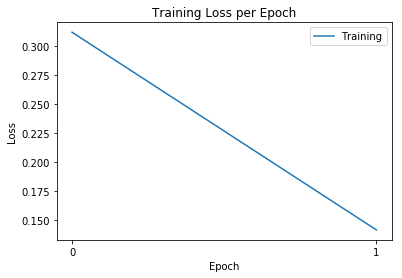

Session Saved.


In [7]:
tf.reset_default_graph()
with tf.Session() as session:
    image_shape = X.shape[1:]
    model = models.model1(image_shape)
    fit(session, model, X, Y, epochs=2, shuffle=True, verbose=True, print_interval=10)
    
    # Save Model
    # https://www.tensorflow.org/programmers_guide/saved_model
    save_path = os.path.join(os.getcwd(), "savedmodels\\model1\\model1.ckpt")
    saver = tf.train.Saver()
    saver.save(session, save_path)
    print("Session Saved.")